# Twitter Sentiment Analysis

## Intoduction

In this project, I will do a Twitter Sentiment Analysis Task with a several machine learning models for a supervised dataset containing 1.6 million tweets and detailed information about them. Data can be found <a href="https://www.kaggle.com/datasets/kazanova/sentiment140">here</a>.


## Content

<ol>
  <li>Reading and Loading Dataset</li>
  <li>Exploratory Data Analysis of Dataset</li>
  <li>Data Visualization</li>
  <li>Data Preprocessing</li>
  <li>Model Building</li>
  <li>Model Evaluation</li>
  <li>Conclusion</li>
</ol>

I'll start with importing necessary libraries for my project and then read the csv file into pandas dataframe. Then, I will do clearing and preparing the dataset for the following data preprocessing step.

In [1]:
# utilities
import pandas as pd
import numpy as np
import stopwords
import string
from annoy import AnnoyIndex
import joblib
import sys

# visualization 
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# nltk
from nltk.tokenize import RegexpTokenizer
import nltk

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier

# xgboost
import xgboost as xgb

In [2]:
sys.path.append('../scripts')

## 1. Read and load dataset

In [4]:
# importing the dataset

DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
csv_path = "../data/training.1600000.processed.noemoticon.csv"

df = pd.read_csv(csv_path, encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## 2. Exploratory Data Analysis of Dataset

In [5]:
print(f"Features of dataset: {df.columns}")

Features of dataset: Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')


In [6]:
print(f"Length of the dataset: {len(df)}")

Length of the dataset: 1600000


In [7]:
print(f"Shape of dataset: {df.shape}")

Shape of dataset: (1600000, 6)


In [8]:
print("Basic info about dataset: \n")

df.info()

Basic info about dataset: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [9]:
print("Datatypes of all columns:")

df.dtypes

Datatypes of all columns:


target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

In [10]:
print("Checking for null values:")

df.isnull().sum()

Checking for null values:


target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [11]:
print("Checking for unique values of target variable:")
df['target'].unique()

Checking for unique values of target variable:


array([0, 4], dtype=int64)

In [12]:
print(f"Number of unique values of target variable: {df['target'].nunique()}")

Number of unique values of target variable: 2


## 3. Data Visualization of Target Variable

[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

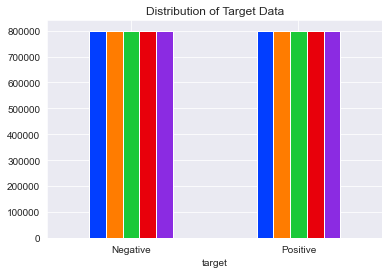

In [13]:
# plotting the distribution of target data

colour_palette = sns.color_palette("bright")

ax = df.groupby('target').count().plot(kind='bar', title="Distribution of Target Data", legend=False, color=colour_palette)
ax.set_xticklabels(['Negative', 'Positive'], rotation=0)

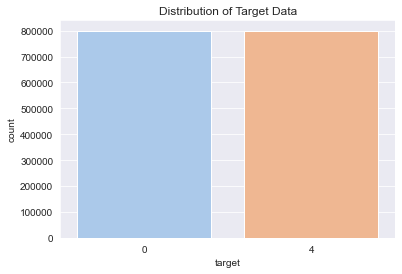

In [14]:
sns.countplot(x=df['target'], hue=df['target'], palette="pastel", data=df, legend=False)
plt.title("Distribution of Target Data")
plt.show()

## 4. Data Preprocessing 

There are much information that can be useless for the analysis in the dataset. Therefore, I'll be using only 2 columns: "Text" which is the tweets itself and "Target" describing the polarity of the tweets. 

In [ ]:
# importing necessary data preprocessing functions from the python file (preprocessing_data.py)

from preprocessing_data import remove_stopwords, remove_punctuations, remove_URLs, remove_numbers, stemming, lemmatizing

In [15]:
# storing data in lists

text, sentiment = [df['text'], df['target']]

In [16]:
# selecting target and text columns for the further analysis

data = df[['target','text']]
data.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [17]:
# replacing the values for the easier understanding 

data.loc[data['target'] == 4, 'target'] = 1

In [18]:
print(f"Unique values of target variable: {data['target'].unique()}")

Unique values of target variable: [0 1]


In [19]:
# separating the positive and negative tweets

pos_tweets = data[data['target'] == 1]
neg_tweets = data[data['target'] == 0]

In [20]:
# taking one-fourth of the data for easier model training on our machine

pos_tweets = pos_tweets.iloc[:20000]
neg_tweets = neg_tweets.iloc[:20000]

# combining positive and negative tweets into one dataset

dataset = pd.concat([pos_tweets, neg_tweets])

In the above-given problem, before training the models, I performed next various preprocessing steps on the dataset that mainly dealt with removing the stopwords, special symbols, emojis, hashtags, mentions (the words starting with "@"), etc. The text document is converted into the lower case for the purpose of better generalization.

Subsequently, I'll reduce the noice from the dataset by removing punctuations and URLs as they don't have any significant information. 

At last, I'll perform the stemming and lemmatization for better results.

In [21]:
# converting statement texts into lower case

dataset['text'] = dataset['text'].str.lower()
dataset.head()

,target,text
800000,1,i love @health4uandpets u guys r the best!!
800001,1,im meeting up with one of my besties tonight! ...
800002,1,"@darealsunisakim thanks for the twitter add, s..."
800003,1,being sick can be really cheap when it hurts t...
800004,1,@lovesbrooklyn2 he has that effect on everyone


In [22]:
# defining the list containing stopwords

stopwords_list = stopwords.get_stopwords("english")
print(stopwords_list)

['', 'a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', "can't", 'cannot', 'could', "couldn't", 'did', "didn't", 'do', 'does', "doesn't", 'doing', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', "hadn't", 'has', "hasn't", 'have', "haven't", 'having', 'he', "he'd", "he'll", "he's", 'her', 'here', "here's", 'hers', 'herself', 'him', 'himself', 'his', 'how', "how's", 'i', "i'd", "i'll", "i'm", "i've", 'if', 'in', 'into', 'is', "isn't", 'it', "it's", 'its', 'itself', "let's", 'me', 'more', 'most', "mustn't", 'my', 'myself', 'no', 'nor', 'not', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours ourselves', 'out', 'over', 'own', 'same', "shan't", 'she', "she'd", "she'll", "she's", 'should', "shouldn't", 'so', 'some', 'such', 'than', 'that', "that's", 'the', 'their', 'theirs', 'them', 'themselves', '

In [23]:
# cleaning and removing all the stopwords from the tweets

dataset['text'] = dataset['text'].apply(lambda text: remove_stopwords(text, stopwords_list))
dataset.head()

,target,text
800000,1,love @health4uandpets u guys r best!!
800001,1,im meeting one besties tonight! cant wait!! - ...
800002,1,"@darealsunisakim thanks twitter add, sunisa! g..."
800003,1,sick can really cheap hurts much eat real food...
800004,1,@lovesbrooklyn2 effect everyone


In [24]:
# cleaning and removing all the punctuations

english_punctuations = string.punctuation
print(english_punctuations)

dataset['text'] = dataset['text'].apply(lambda text: remove_punctuations(text, english_punctuations))
dataset.head()

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


,target,text
800000,1,love health4uandpets u guys r best
800001,1,im meeting one besties tonight cant wait girl...
800002,1,darealsunisakim thanks twitter add sunisa got ...
800003,1,sick can really cheap hurts much eat real food...
800004,1,lovesbrooklyn2 effect everyone


In [25]:
# cleaning and removing all the URLs

dataset['text'] = dataset['text'].apply(remove_URLs)
dataset.head()

,target,text
800000,1,love health4uandpets u guys r best
800001,1,im meeting one besties tonight cant wait girl...
800002,1,darealsunisakim thanks twitter add sunisa got ...
800003,1,sick can really cheap hurts much eat real food...
800004,1,lovesbrooklyn2 effect everyone


In [26]:
# cleaning and removing all the numeric numbers

dataset['text'] = dataset['text'].apply(remove_numbers)
dataset.head()

,target,text
800000,1,love health uandpets u guys r best
800001,1,im meeting one besties tonight cant wait girl...
800002,1,darealsunisakim thanks twitter add sunisa got ...
800003,1,sick can really cheap hurts much eat real food...
800004,1,lovesbrooklyn effect everyone


In [27]:
# getting tokenization of the tweet texts

tokenizer = RegexpTokenizer(r'\w+')

dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset.head()

,target,text
800000,1,"[love, health, uandpets, u, guys, r, best]"
800001,1,"[im, meeting, one, besties, tonight, cant, wai..."
800002,1,"[darealsunisakim, thanks, twitter, add, sunisa..."
800003,1,"[sick, can, really, cheap, hurts, much, eat, r..."
800004,1,"[lovesbrooklyn, effect, everyone]"


In [28]:
# applying stemming 

st = nltk.PorterStemmer()

dataset['text'] = dataset['text'].apply(lambda text: stemming(text, st))
dataset.head()

,target,text
800000,1,"[love, health, uandpets, u, guys, r, best]"
800001,1,"[im, meeting, one, besties, tonight, cant, wai..."
800002,1,"[darealsunisakim, thanks, twitter, add, sunisa..."
800003,1,"[sick, can, really, cheap, hurts, much, eat, r..."
800004,1,"[lovesbrooklyn, effect, everyone]"


In [29]:
# applying lemmatizer

lm = nltk.WordNetLemmatizer()

dataset['text'] = dataset['text'].apply(lambda text: lemmatizing(text, lm))
dataset.head()

,target,text
800000,1,"[love, health, uandpets, u, guys, r, best]"
800001,1,"[im, meeting, one, besties, tonight, cant, wai..."
800002,1,"[darealsunisakim, thanks, twitter, add, sunisa..."
800003,1,"[sick, can, really, cheap, hurts, much, eat, r..."
800004,1,"[lovesbrooklyn, effect, everyone]"


In [30]:
# separating input features and labels

Xdata = data['text'].astype(str)
ydata = data['target']

Wordclouds give us a good idea about the number of repeating words and which words make up the positive or negative tweets.

We see that there are some positive words such as "thank" and "good" which make up most of the positive reviews. There are also some words that occur quite rare such as "love" but these words also make a mark in the decisions respectively. In addition to this, we also find that there are very few words that are negative in the positive text. Therefore, we can conclude that words are a good indication of the polarity and sentiment of the text respectively.

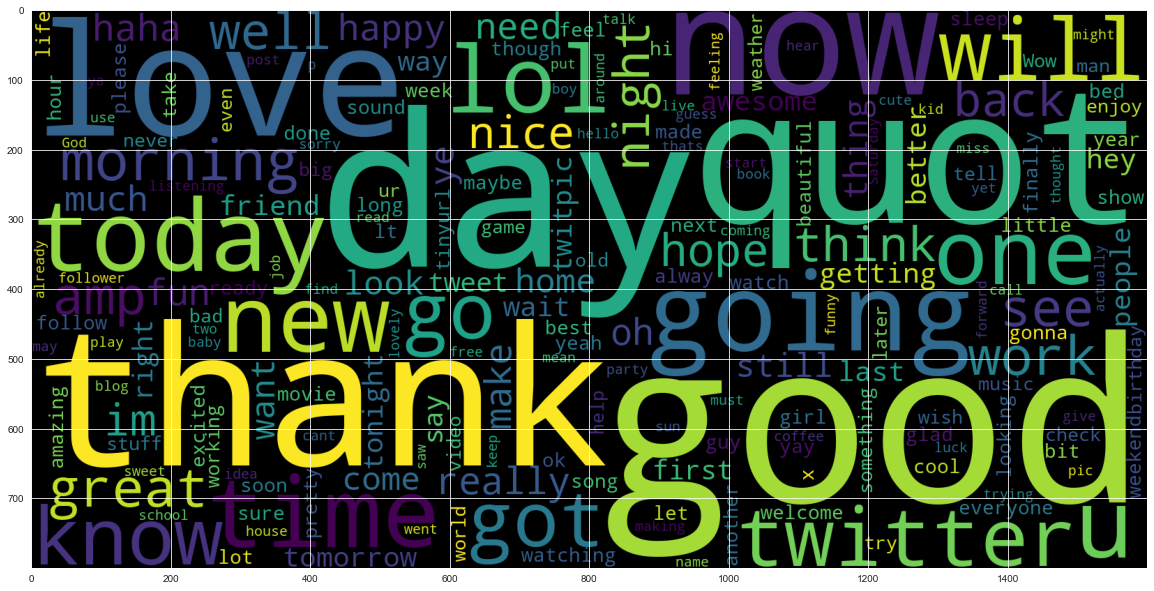

In [31]:
# plotting a cloud of words for positive tweets

pos_data = pos_tweets['text']
plt.figure(figsize=(20, 20))

wc = WordCloud(max_words=200, width=1600, height=800, collocations=False).generate(" ".join(pos_data))
plt.imshow(wc)

As can be seen in the negative wordcloud, there are some words such as "work" and "now" which are considered to be negative respectively. Therefore, getting the wordcloud would ensure that we get to know the words present in the wordcloud dictionary and ensure that we understand the full context of the review respectively.

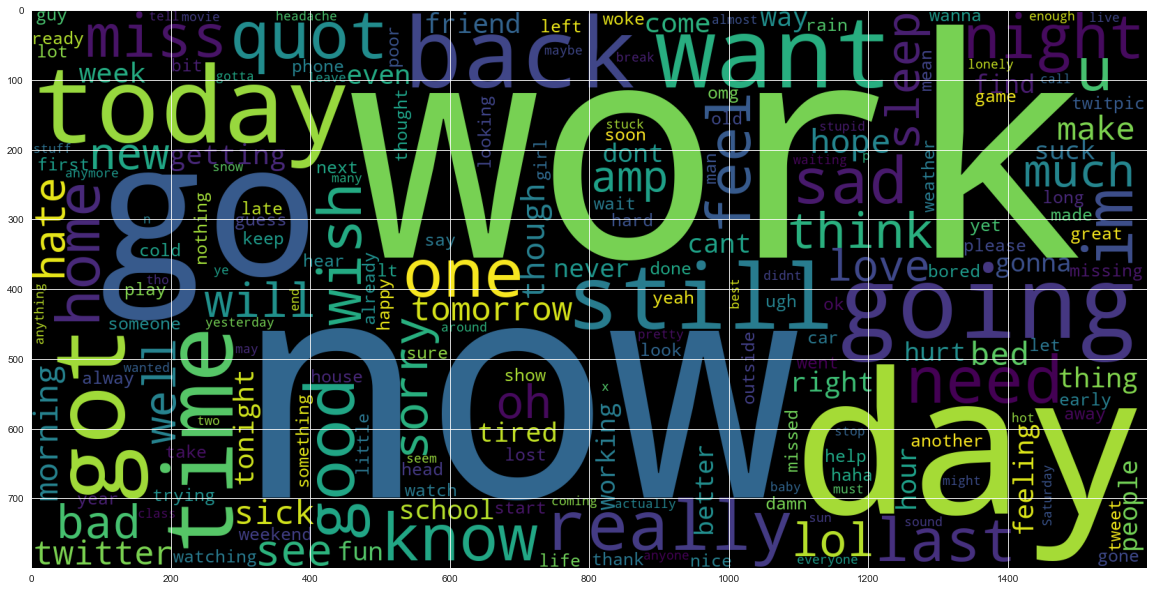

In [32]:
# plotting a cloud of words for positive tweets

neg_data = neg_tweets['text']
plt.figure(figsize=(20, 20))

wc = WordCloud(max_words=200, width=1600, height=800, collocations=False).generate(" ".join(neg_data))
plt.imshow(wc)

## 5. Splitting Our Dataset Into Train, Validation and Test Subsets

Now I'm going to divide the data into training, validation and test data to ensure that we understand the machine learning model well. I'll separate the data into 3 parts where 60% of the data will be taken as the training data, the 20 percent of the data will be taken as the validation data and the remaining 20% will be taken as the test data. There is a random state assigned to it and split to ensure that we get a good accuracy.

In [33]:
# separating the 60% data for training, 20% for validation and 20% for testing

Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size=0.4, random_state=42)
Xval, Xtest, yval, ytest = train_test_split(Xtest, ytest, test_size=0.5, random_state=42)
# 
print(f"Shape of train subset: {Xtrain.shape}")
print(f"Shape of validation subset: {Xval.shape}")
print(f"Shape of test subset: {Xtest.shape}")

Shape of train subset: (960000,)
Shape of validation subset: (320000,)
Shape of test subset: (320000,)


## 6. Transforming the Dataset Using TF-IDF Vectorizer

With the help of Tfidf Vectorizer, it is easy to convert the text into the form of vector based on the word frequency and the inverse document frequency and get those values which could be fed to the machine learning models for prediction respectively. Having a look at those values, we are going to be taking them and predicting using the machine learning approach.

In [34]:
# fitting the TF-IDF Vectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=500000)
vectorizer.fit(Xtrain)
print(f"Number of feature words: {len(vectorizer.get_feature_names_out())}")

Number of feature words: 500000


In [35]:
Xtrain.shape

(960000,)

In [36]:
# transforming the subdatasets using TF-IDF Vectorizer

Xtrain = vectorizer.transform(Xtrain)
Xval = vectorizer.transform(Xval)
Xtest = vectorizer.transform(Xtest)

## 7. Machine Learning Model Building

In the problem statement, I'll use some different models respectively :

<ol>
  <li>Logistig Regression</li>
  <li>Support Vector Machine (SVM)</li>
  <li>Multinomial Naive Bayes</li>
  <li>K Nearest Neighbours (kNN)</li>
  <li>Random Forest</li>
  <li>eXtreme Gradient Boosting (XGBoost)</li>
</ol>

The idea behind choosing these models is that we want to try all the classifiers on the dataset ranging from simple ones to complex models, and then try to find out the one which gives the best performance among them.

### 7.1 Evaluating the models

After training the model, I'll then apply the evaluation measures to check how the model is performing. Accordingly, I use the following evaluation parameters to check the performance of the models respectively:

<ol>
  <li>Accuracy Score</li>
  <li>F1 Score</li>
  <li>ROC-AUC Curve</li>
  <li>Confusion Matrix with Plot</li>
</ol>

In [38]:
# importing the function for the model evaluation from the python file (evaluate_model.py) 

from evaluate_model import evaluate_model

In [36]:
model_metrics = {
    "Accuracy": [],
    "F1 Score": [],
    "ROC AUC": [],
}

model_names = ["Logistic Regression", "Support Vector Machine", "Naive Bayes", "KNN", "Random Forest", "XGBoost"]

### 7.2 Logistic Regression Model

In [39]:
LRmodel = LogisticRegression()
LRmodel.fit(Xtrain, ytrain)

LogisticRegression()

              precision    recall  f1-score   support

           0       0.83      0.81      0.82    159939
           1       0.82      0.83      0.82    160061

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000

Accuracy: 0.8224375
F1 score: 0.823917
ROC AUC score for: 0.9015508186785388


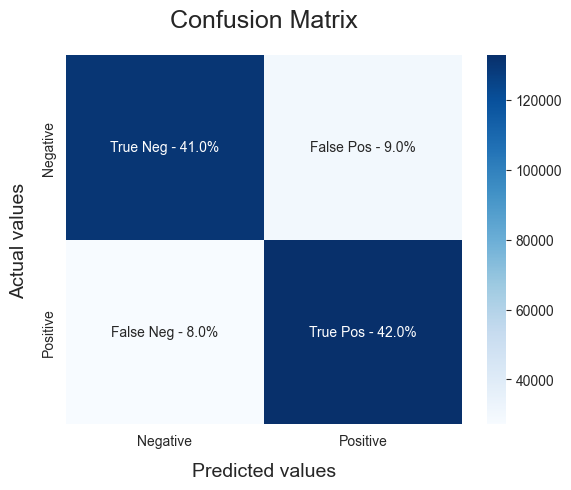

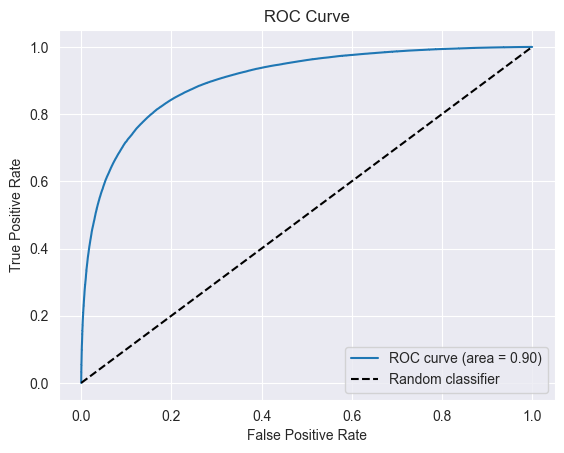

In [38]:
acc, f1, roc = evaluate_model(LRmodel, Xval, yval)

model_metrics["Accuracy"].append(acc)
model_metrics["F1 Score"].append(f1)
model_metrics["ROC AUC"].append(roc)

### 7.3 Support Vector Machine Model

In [39]:
SVMmodel = LinearSVC()
SVMmodel = CalibratedClassifierCV(SVMmodel)
SVMmodel.fit(Xtrain, ytrain)

CalibratedClassifierCV(estimator=LinearSVC())

              precision    recall  f1-score   support

           0       0.82      0.81      0.81    159939
           1       0.81      0.82      0.82    160061

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000

Accuracy: 0.81595
F1 score: 0.817123
ROC AUC score for: 0.8957435554906941


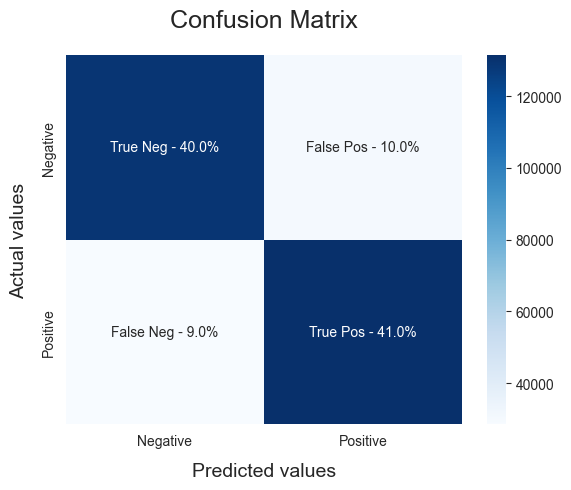

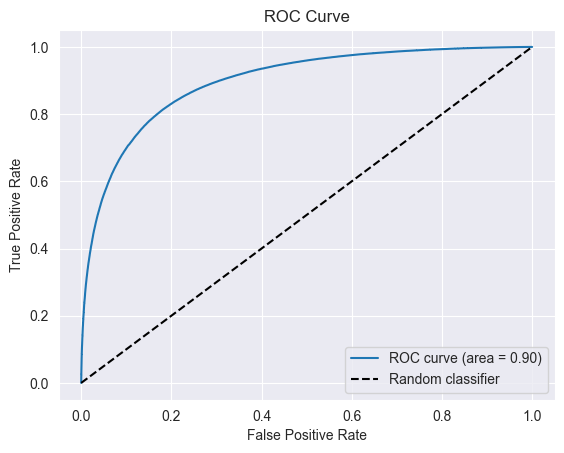

In [40]:
acc, f1, roc = evaluate_model(SVMmodel, Xval, yval)

model_metrics["Accuracy"].append(acc)
model_metrics["F1 Score"].append(f1)
model_metrics["ROC AUC"].append(roc)

### 7.4 Multinomial Naive Bayes Model

In [41]:
MNBmodel = MultinomialNB()
MNBmodel.fit(Xtrain, ytrain)

MultinomialNB()

              precision    recall  f1-score   support

           0       0.79      0.82      0.81    159939
           1       0.81      0.78      0.80    160061

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000

Accuracy: 0.80305
F1 score: 0.799393
ROC AUC score for: 0.8851750061811015


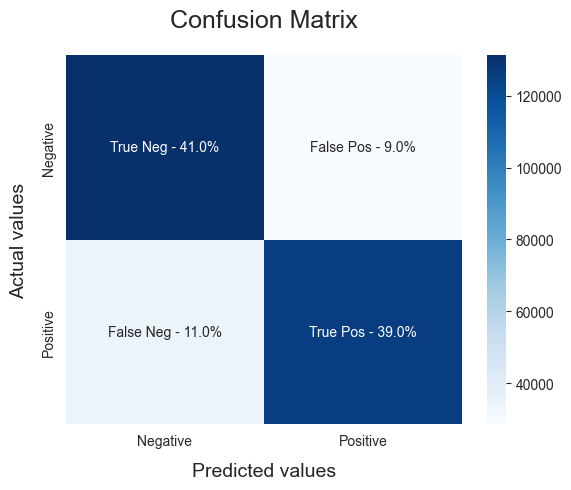

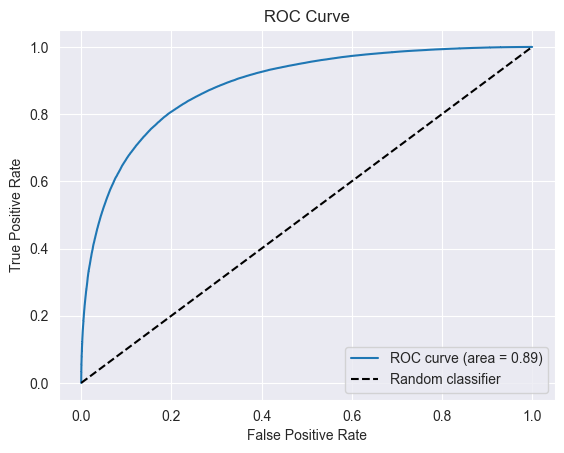

In [42]:
acc, f1, roc = evaluate_model(MNBmodel, Xval, yval)

model_metrics["Accuracy"].append(acc)
model_metrics["F1 Score"].append(f1)
model_metrics["ROC AUC"].append(roc)

### 7.5 K-Nearest Neighbors Algorithm Model

#### 7.5.1 Data Standardization 

In [43]:
scaler = StandardScaler(with_mean=False)

Xtrain_scaled = scaler.fit_transform(Xtrain)
Xval_scaled = scaler.transform(Xval)

#### 7.5.2 Principal Components Analysis Method

In [44]:
pca = PCA(n_components=100)

Xtrain_pca = pca.fit_transform(Xtrain_scaled)
Xval_pca = pca.transform(Xval_scaled)

#### 7.5.3 ANNOY-Powered kNN Model

In [45]:
class AnnoyKNN(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=30, n_trees=30, metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.n_trees = n_trees
        self.metric = metric

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y.to_numpy()
        self.annoy_index = AnnoyIndex(X.shape[1], self.metric)

        for i in range(len(X)):
            self.annoy_index.add_item(i, X[i].tolist())

        self.annoy_index.build(self.n_trees)
        return self
    
    def predict(self, X):
        predictions = []
        for item in X:
            indices = self.annoy_index.get_nns_by_vector(item, self.n_neighbors)
            labels = self.y_train[indices]
            predictions.append(np.argmax(np.bincount(labels)))
        
        return np.array(predictions)
    
    def predict_proba(self, X):
        probas = []
        for item in X:
            indices = self.annoy_index.get_nns_by_vector(item, self.n_neighbors)
            labels = self.y_train[indices]
            counts = np.bincount(labels, minlength=2)
            probas.append(counts / counts.sum())
            
        return np.array(probas)

#### 7.5.4 Applying kNN Model

In [46]:
annoy_knn_model = AnnoyKNN(n_neighbors=30, n_trees=30, metric='euclidean')
annoy_knn_model.fit(Xtrain_pca, ytrain)

AnnoyKNN()

              precision    recall  f1-score   support

           0       0.63      0.72      0.67    159939
           1       0.67      0.57      0.62    160061

    accuracy                           0.65    320000
   macro avg       0.65      0.65      0.65    320000
weighted avg       0.65      0.65      0.65    320000

Accuracy: 0.647165625
F1 score: 0.619513
ROC AUC score for: 0.709722299409245


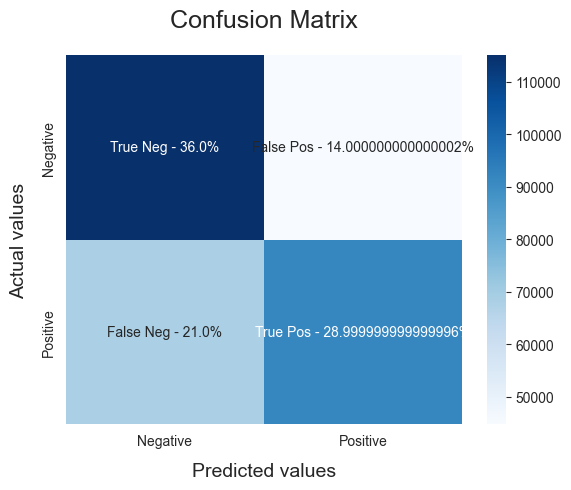

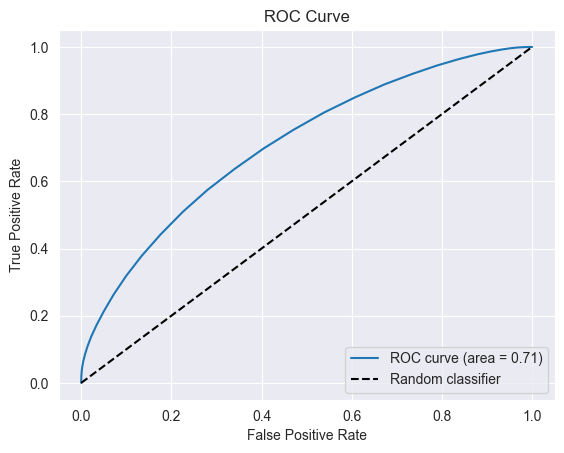

In [48]:
acc, f1, roc = evaluate_model(annoy_knn_model, Xval_pca, yval)

model_metrics["Accuracy"].append(acc)
model_metrics["F1 Score"].append(f1)
model_metrics["ROC AUC"].append(roc)

### 7.6 Random Forest Model

In [49]:
RFmodel = RandomForestClassifier(n_estimators=100, max_depth=30)
RFmodel.fit(Xtrain, ytrain)

RandomForestClassifier(max_depth=30)

              precision    recall  f1-score   support

           0       0.76      0.72      0.74    159939
           1       0.74      0.78      0.75    160061

    accuracy                           0.75    320000
   macro avg       0.75      0.75      0.75    320000
weighted avg       0.75      0.75      0.75    320000

Accuracy: 0.747871875
F1 score: 0.754683
ROC AUC score for: 0.8226830233087317


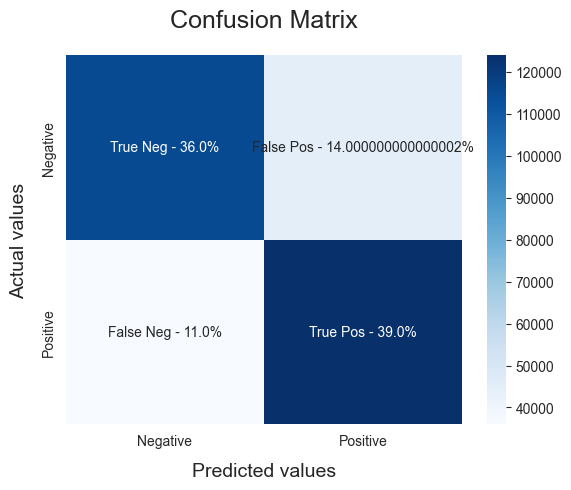

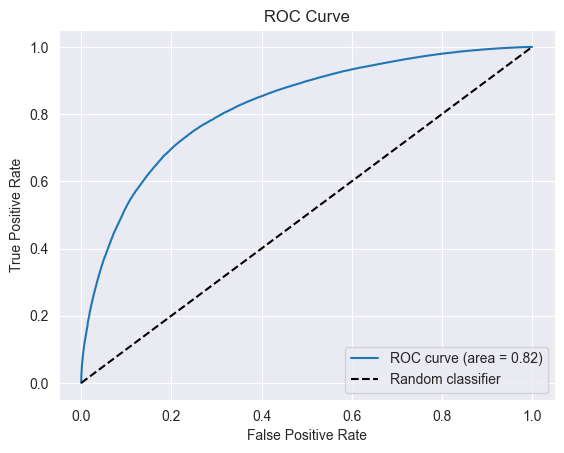

In [50]:
acc, f1, roc = evaluate_model(RFmodel, Xval, yval)

model_metrics["Accuracy"].append(acc)
model_metrics["F1 Score"].append(f1)
model_metrics["ROC AUC"].append(roc)

### 7.7 XGBoost Model

In [51]:
XGBmodel = xgb.XGBClassifier(device="cuda")
XGBmodel.fit(Xtrain, ytrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

D:\Pet projects\Twitter_Sentiment_Analysis\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [12:56:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.79      0.73      0.76    159939
           1       0.75      0.80      0.77    160061

    accuracy                           0.76    320000
   macro avg       0.77      0.76      0.76    320000
weighted avg       0.77      0.76      0.76    320000

Accuracy: 0.7645875
F1 score: 0.773068
ROC AUC score for: 0.8445401297083525


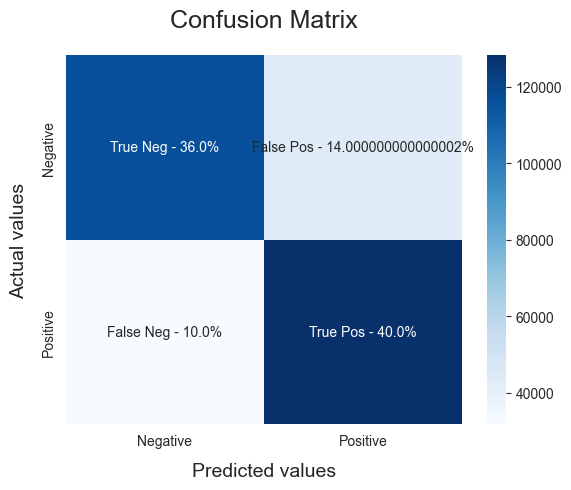

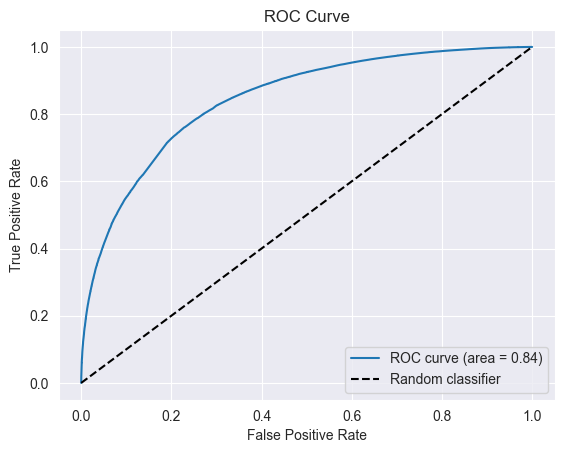

In [52]:
acc, f1, roc = evaluate_model(XGBmodel, Xval, yval)

model_metrics["Accuracy"].append(acc)
model_metrics["F1 Score"].append(f1)
model_metrics["ROC AUC"].append(roc)

## 8. Model Evaluation. Best Model Selection

In [53]:
# create pandas dataframe of models and their corresponding metrics    
metrics_df = pd.DataFrame(model_metrics, model_names)
metrics_df = metrics_df.sort_values(by="Accuracy", ascending=False)

print(metrics_df)

                        Accuracy  F1 Score   ROC AUC
Logistic Regression     0.822438  0.823917  0.901551
Support Vector Machine  0.815950  0.817123  0.895744
Naive Bayes             0.803050  0.799393  0.885175
XGBoost                 0.764587  0.773068  0.844540
Random Forest           0.747872  0.754683  0.822683
KNN                     0.647166  0.619513  0.709722


In [54]:
# get the highest scores
highest_acc = metrics_df["Accuracy"].max()
highest_f1 = metrics_df["F1 Score"].max()
highest_roc = metrics_df["ROC AUC"].max()

# get the corresponding model names 
highest_acc_model = metrics_df["Accuracy"].idxmax()
highest_f1_model = metrics_df["F1 Score"].idxmax()
highest_roc_model = metrics_df["ROC AUC"].idxmax()

# print the results
print(f"Highest Accuracy: {highest_acc} by {highest_acc_model}")
print(f"Highest F1 Score: {highest_f1} by {highest_f1_model}")
print(f"Highest ROC AUC: {highest_roc} by {highest_roc_model}")

Highest Accuracy: 0.8224375 by Logistic Regression
Highest F1 Score: 0.8239166005553352 by Logistic Regression
Highest ROC AUC: 0.9015508186785388 by Logistic Regression


Upon evaluating all the models, I can conclude the following details i.e.

Logistic Regression, Support Vector Machine and Multinomial Naive Bayes models have a much better performance than XGBoost, Random Forest and kNN models. Among the better performing models, I can see that the Logistic Regression has the highest metrics score.

I, therefore, conclude that the Logistic Regression is the best model for the above-given dataset.

In [40]:
# save the best model

joblib.dump(LRmodel, "../models/twitter_logistic_model.pkl")

['../models/twitter_logistic_model.pkl']

In [41]:
# save the fitted vectorizer

joblib.dump(vectorizer, '../vectorizer/fitted_vectorizer.pkl')

['../vectorizer/fitted_vectorizer.pkl']

## 9. Testing Model

              precision    recall  f1-score   support

           0       0.83      0.81      0.82    159790
           1       0.82      0.83      0.82    160210

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000

Accuracy: 0.821496875
F1 score: 0.823057
ROC AUC score for: 0.9007762624505147


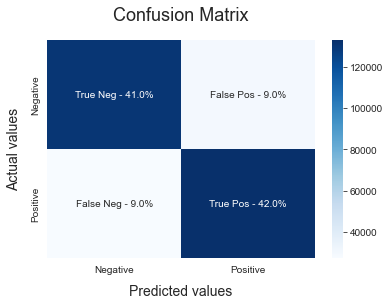

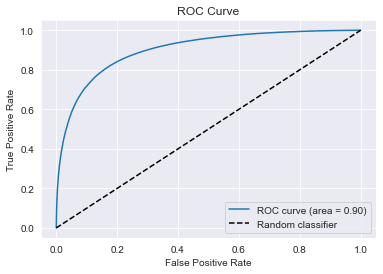

(0.821496875, 0.823056740422711, 0.9007762624505147)

In [42]:
evaluate_model(LRmodel, Xtest, ytest)

## Conclusion

It would be a good idea to use some tools such as wordcloud when we are doing Natural Language Processing (NLP) to ensure that we are getting the best results for predictions respectively. We would be able to understand the frequently occurring words from the less frequently occurring words by the size of the words that are plotted in the wordcloud respectively.

Steps should be taken to ensure that the model does not overfit or underfit. This ensures that the best predictions are being generated and therefore, we are going to get the best outputs respectively.

In conclusion, the model is pretty good at predicting the 'negative' tweets correctly with 0.83 precision, 0.81 recall and 0.82 f-1 scores and at predicting the 'positive' tweets correctly with 0.83 precision, 0.82 recall and 0.83 f-1 scores. Overall, it has 82.3% accuracy rate at predicting which class a tweet belongs to.